# Monk3
Grid Search for Monk1 dataset model selection


In [137]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.Validation.KFoldCrossValidation import validate
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk3
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk3 dataset 

In [138]:
training_data, training_labels, test_data, test_labels = read_monk3("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [139]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [140]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [141]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()][1]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 64
epochs = 500

final_file = 'monk3_models_configs_hist3.json'

if not os.path.exists(final_file):
    dir_path = "Monk3/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = [1]#all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid", 'tanh']
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=100, workers=4, number_of_initializations=3, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_file)
else: 
    with open(final_file, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [142]:
my_configs = []
for config in configs[1]:
    config['callbacks'] = ['earlystopping_1e-4_50_False_True']
# ea = EarlyStoppingCallback(restore_weights=True)
if __name__ == '__main__':
    # for config in configs[1]:
    #     config['callbacks'] = [ea]
    my_configs.append(
        validate(configs[1], x=training_data, y_true=training_labels, epochs=epochs, return_models_history=True,
                          batch_size=batch_size, max_configs=100, number_of_initializations=2, n_splits=4, parallel=False
                          ))
    
    # my_configs.append(
    #     hold_out(configs[1], training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
    #                       batch_size=batch_size, num_models=100, number_of_initializations=2,
    #                       ))

configs=my_configs[0]

Models: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [143]:
models = []
old_histories = configs[0]
configs=configs[1]
with tqdm(total=len(configs)) as pbar:
    for old_hist, config in zip(old_histories, configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, old_hist['binary_accuracy'][-1],  old_hist['val_binary_accuracy'][-1], old_hist['mse'],  old_hist['val_mse'], model.history['mse'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


In [148]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 0.95] 
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 0.96]
df_sorted = df_sorted[df_sorted['Old_Accuracy_val'] >= 0.97]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.1] 
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
10,0.035269,0.047779,0.95082,0.031638,0.965278,500,0.945055,1.0,"[0.27626988, 0.26945004, 0.26339966, 0.2581947...","[0.27007708, 0.26306462, 0.25685358, 0.2515626...","[0.27904582, 0.27244747, 0.26662406, 0.2614868...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-07, 'learning_rate': 0.2...",1,[3],Model2427


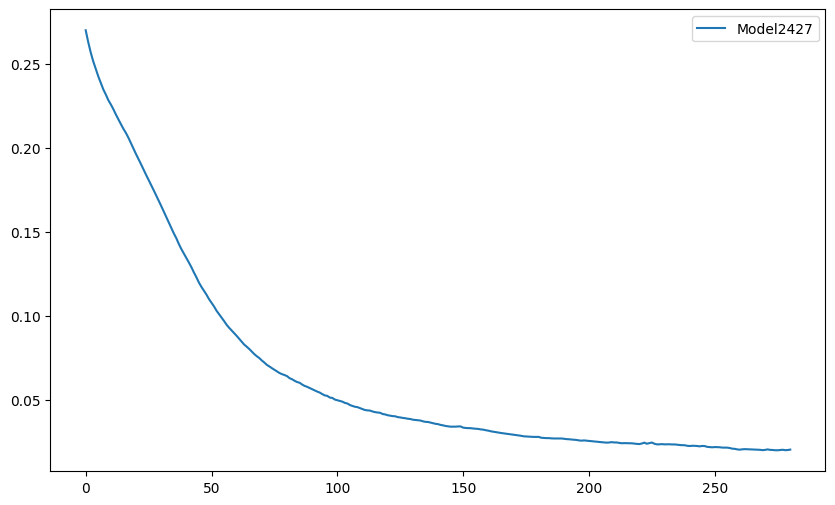

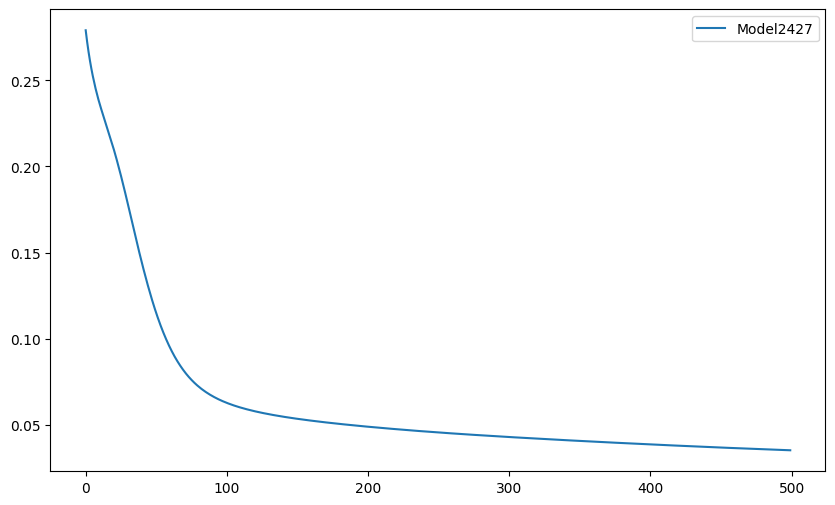

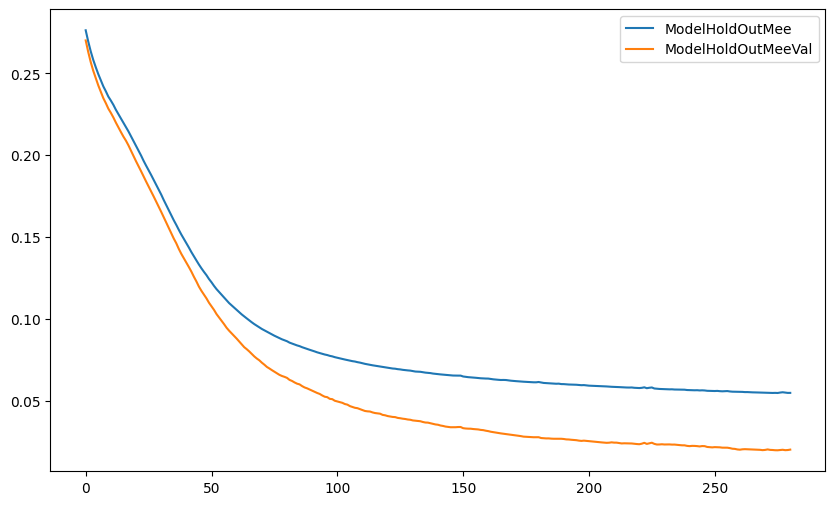

In [149]:
plot_history(old_histories_val)
plot_history({list(histories)[0]: list(histories.values())[0]})
plot_history({'ModelHoldOutMee': list(old_histories.values())[0], 'ModelHoldOutMeeVal': list(old_histories_val.values())[0]})
# plot_history({list(histories)[1]: list(histories.values())[1]})


Score                                                        0.035269
History_Std                                                  0.047779
Accuracy                                                      0.95082
Test_Score                                                   0.031638
Test_Accuracy                                                0.965278
Trained_Epochs                                                    500
Old_Accuracy                                                 0.945055
Old_Accuracy_val                                                  1.0
Old_History         [0.27626988, 0.26945004, 0.26339966, 0.2581947...
Old_History_val     [0.27007708, 0.26306462, 0.25685358, 0.2515626...
History             [0.27904582, 0.27244747, 0.26662406, 0.2614868...
Model               <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config              {'regularization': 1e-07, 'learning_rate': 0.2...
Num_Layers                                                          1
Num_of_Units        

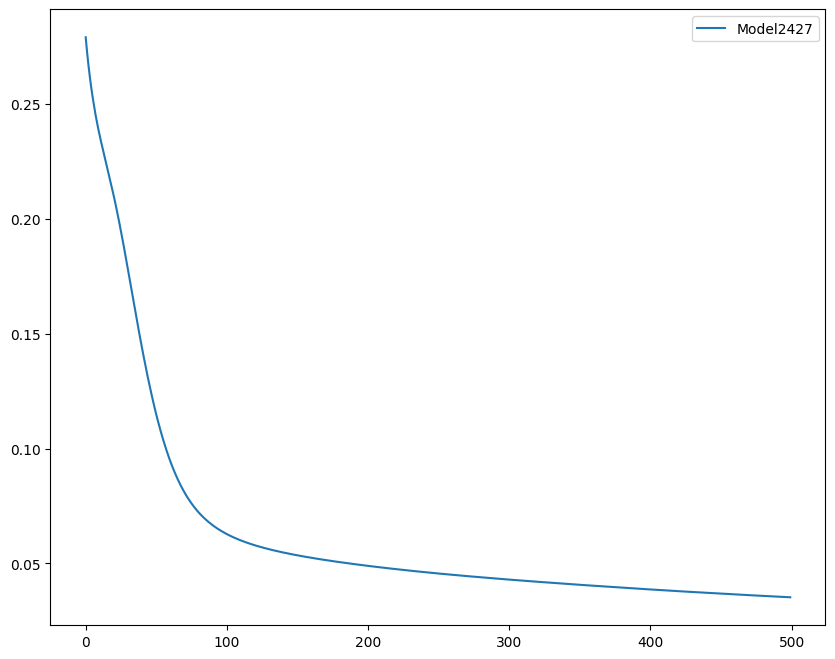

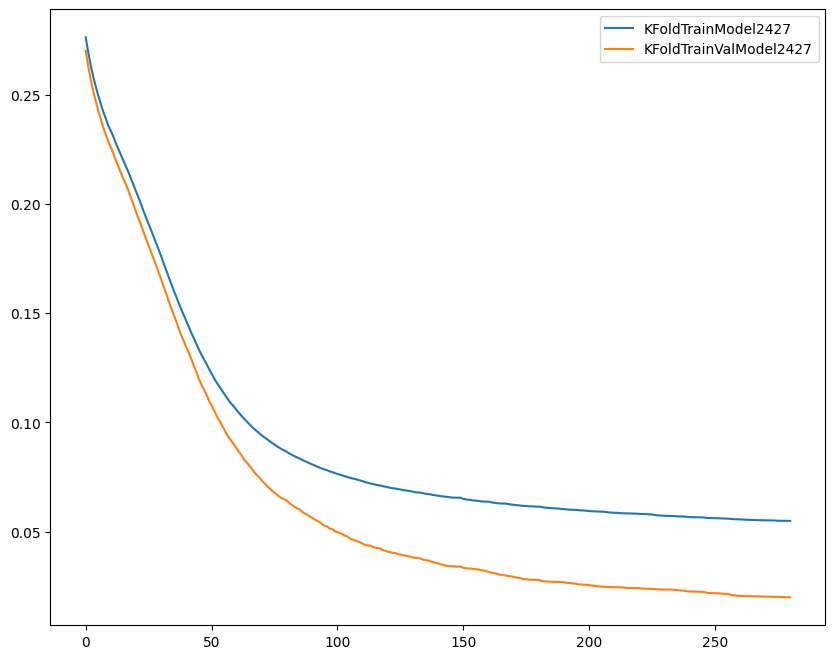

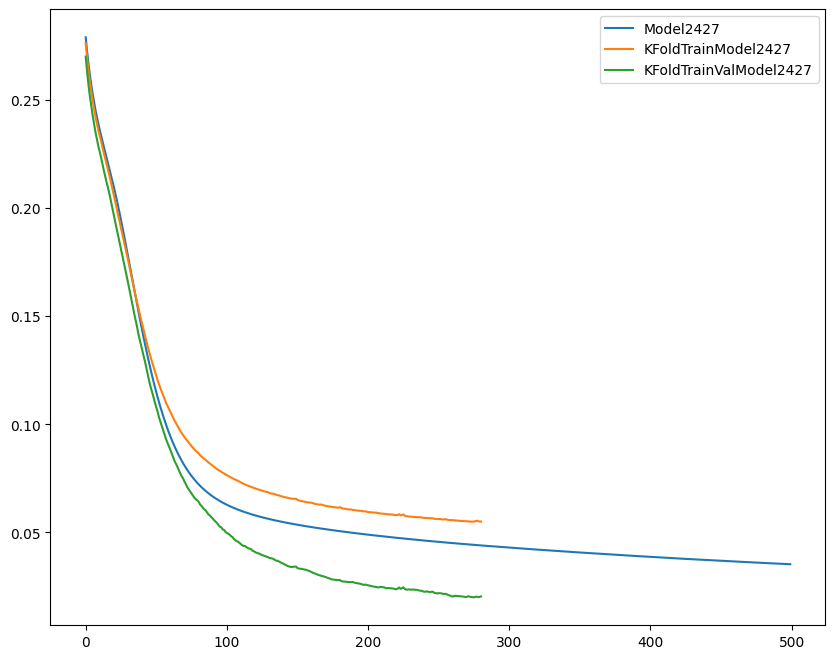

In [152]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array1 = np.array(row['History'])
        differences1 =  (np.diff(array1) - np.mean(array1)) /np.mean(array1)
        min_consecutive_difference = np.min(differences1)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

result_row = find_least_difference_row(df_sorted)
# Pivot the DataFrame using 'Unnamed: 0' as both index and columns
print(result_row)
plot_history({result_row['Name']: result_row['History']}, fig_size=(10,8))
plot_history({'KFoldTrain'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'KFoldTrainVal'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8))
plot_history({result_row["Name"]: result_row['History'], 'KFoldTrain'+result_row["Name"]: result_row['Old_History'], 'KFoldTrainVal'+result_row["Name"]: result_row['Old_History_val']}, fig_size=(10,8))
#Df sorted to pickle 
result_row.to_csv('Monk3_train.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


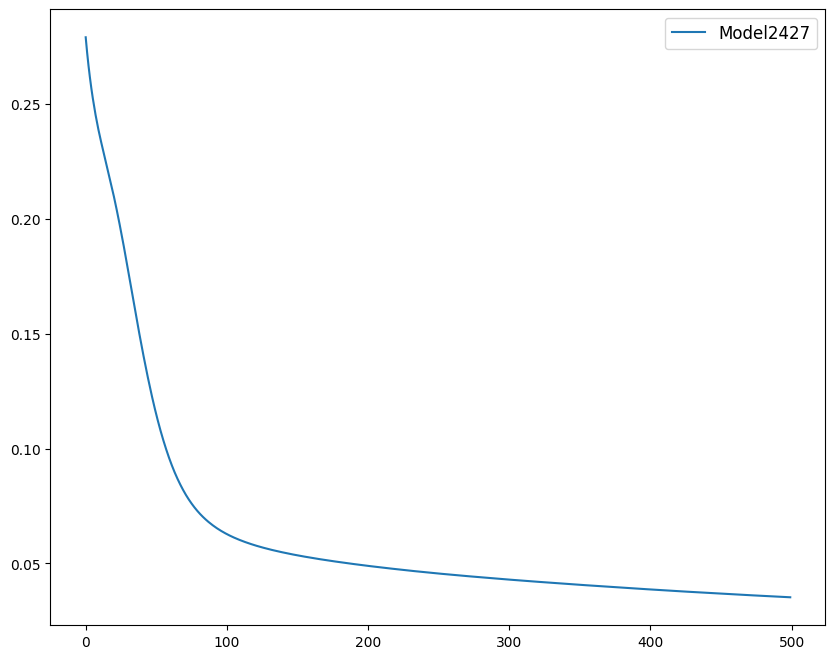

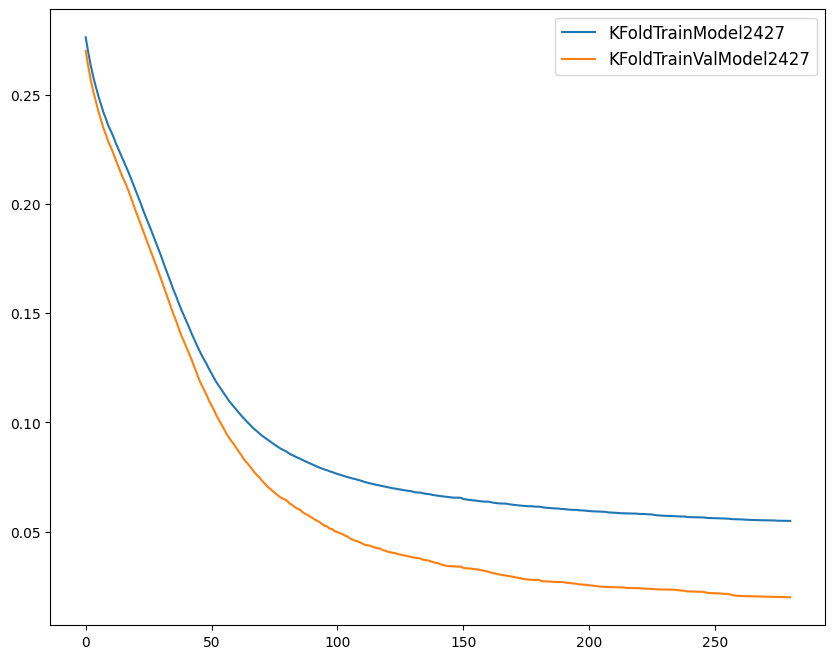

In [151]:
import matplotlib.pyplot as plt
def plot_history2(name, lines: dict, fig_size=(10, 6)):
    plt.figure(figsize=fig_size)
    for elem in lines:
        plt.plot(lines[elem], label=elem)
    plt.legend(fontsize=12)
    plt.savefig(name+'.eps', format='eps')
    plt.savefig(name+'.png', format='png')
    
plot_history2(name='Monk3_train', lines={result_row["Name"]: result_row['History']}, fig_size=(10,8))
plot_history2(name='Monk3_KFold', lines={'KFoldTrain'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'KFoldTrainVal'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8))
